In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg
!pip install scikit-misc

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

## Preprocessing
### Read data

In [234]:
import gzip
import shutil
data_dir = "../../data/BacDrop/raw_data/"
file_names = ["GSM5456503_Ec_CDS.tsv", "GSM5456504_Efm_CDS.tsv", "GSM5456505_PsA_CDS.tsv", "GSM5456506_Kp_CDS.tsv"]

for f in file_names:
    file_name_full = data_dir + f

    if not f in os.listdir(data_dir):
        if f + ".gz" in os.listdir(data_dir):
            print("unzipping data...")
            with gzip.open(file_name_full + ".gz","rb") as f_in, open(file_name_full,"wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        else:
            raise FileNotFoundError(f"{f} does not exist in regular or zipped form")

In [235]:
adatas = []
for f in file_names:
    file_name_full = data_dir + f
    print(f)
    adata = sc.read_csv(file_name_full, delimiter="\t", first_column_names=True)
    adata = adata.transpose()
    adata.var_names_make_unique()
    adata.X = sps.csr_matrix(adata.X)
    adatas.append(adata)
    
adatas

GSM5456503_Ec_CDS.tsv
GSM5456504_Efm_CDS.tsv
GSM5456505_PsA_CDS.tsv
GSM5456506_Kp_CDS.tsv


[AnnData object with n_obs × n_vars = 9654 × 3642,
 AnnData object with n_obs × n_vars = 9975 × 2350,
 AnnData object with n_obs × n_vars = 8192 × 3478,
 AnnData object with n_obs × n_vars = 8648 × 4539]

In [236]:
adatas[0].obs["species"] = "E.coli"
adatas[1].obs["species"] = "E.faecium"
adatas[2].obs["species"] = "P.Aeruginosa"
adatas[3].obs["species"] = "K.pneumoniae"

adatas[0].var["species"] = "E.coli"
adatas[1].var["species"] = "E.faecium"
adatas[2].var["species"] = "P.Aeruginosa"
adatas[3].var["species"] = "K.pneumoniae"

In [237]:
for x in adatas:
    sc.pp.highly_variable_genes(x, n_top_genes=2000, flavor="seurat_v3", span=1)


In [238]:
data_untr = ad.concat(adatas, join="outer", fill_value=0)
merged_var = pd.concat([x.var for x in adatas], join="outer")
data_untr.var = merged_var[~merged_var.index.duplicated()]
data_untr

AnnData object with n_obs × n_vars = 36469 × 14009
    obs: 'species'
    var: 'species', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'

In [239]:
print(f"Zero inflation of data: {((np.prod(data_untr.X.shape) - data_untr.X.getnnz()) / np.prod(data_untr.X.shape)).round(3)}")


Zero inflation of data: 0.999


### Filter cells

--> filter based on mean absolute standard deviation

In [240]:
importlib.reload(ut)
data_gene = data_untr.copy()
# sc.pp.filter_cells(data_gene, min_genes=15)
# sc.pp.filter_genes(data_gene, min_cells=2)
# sc.pp.calculate_qc_metrics(data_gene, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_gene = ut.filter_outliers(data_untr, nmads=10, min_cells=2, min_genes=15)
# print(data_untr.obs.outlier.value_counts())
print(f"Total number of cells: {data_untr.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

Total number of cells: 36469
Number of cells after filtering: 3525


AnnData object with n_obs × n_vars = 3525 × 4923
    obs: 'species', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'species', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [241]:
print(data_gene.obs["species"].value_counts())

E.faecium       2118
E.coli           985
K.pneumoniae     316
P.Aeruginosa     106
Name: species, dtype: int64


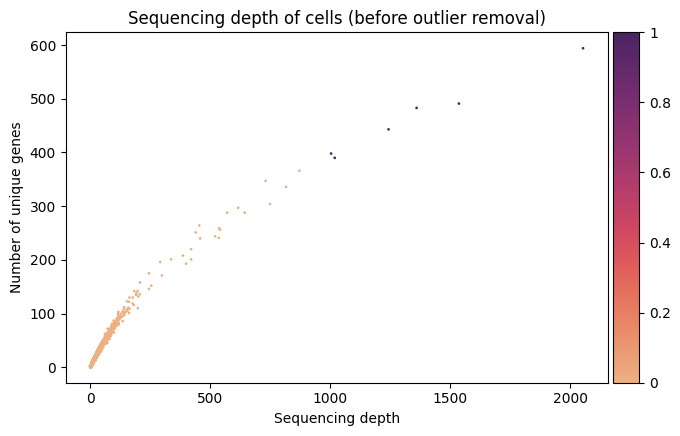

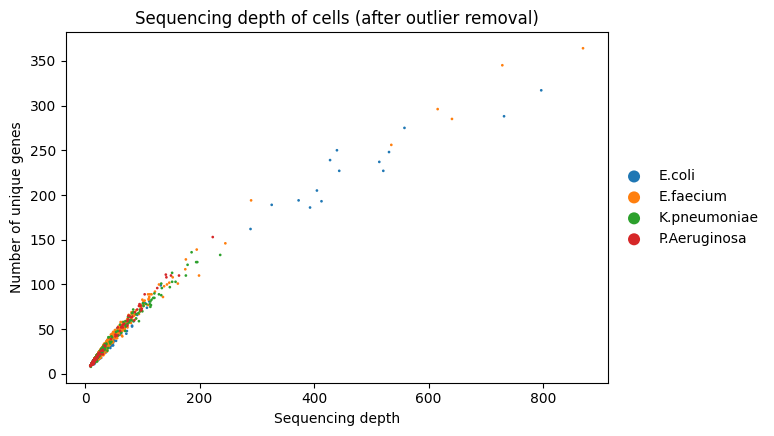

In [242]:
g = sc.pl.scatter(data_untr, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="species")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [243]:
data_gene.layers["counts"] = data_gene.X.copy()

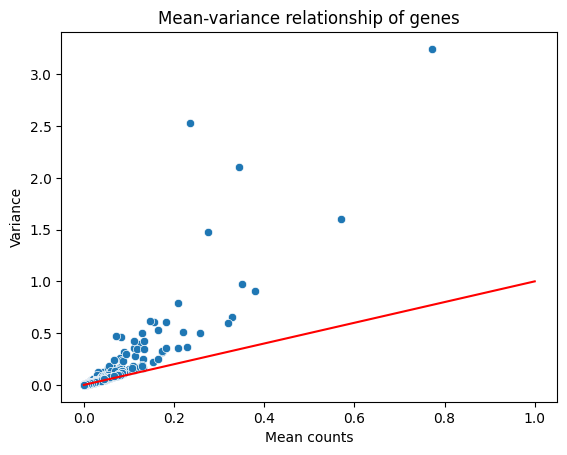

In [244]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [245]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

False


## Estimate negative binomial parameters for each gene

In [246]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

In [247]:
data_gene.var

,species,highly_variable,highly_variable_rank,means,variances,variances_norm,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,...,n_cells,var_counts,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct
cds-ECs_0277,E.coli,True,1895.0,0.000207,0.000207,0.997034,5,0.001418,0.001417,99.858156,...,5,0.001416,False,0.064188,0.064188,-9.885492,2.166170,NaN,NaN,NaN
cds-ECs_1888,E.coli,True,1386.0,0.000104,0.000104,0.999399,2,0.000567,0.000567,99.943262,...,2,0.000567,False,0.030298,0.030298,-9.457674,1.080473,-11.573979,2.709438,0.005778
cds-ECs_2216,E.coli,True,1350.0,0.000104,0.000104,0.999399,3,0.000851,0.000851,99.914894,...,3,0.000850,False,0.042881,0.042881,-10.032974,1.870095,NaN,NaN,NaN
cds-ECs_2217,E.coli,True,1347.0,0.000104,0.000104,0.999399,2,0.000567,0.000567,99.943262,...,2,0.000567,False,0.030298,0.030298,-9.457674,1.080473,NaN,NaN,NaN
cds-ECs_2321,E.coli,True,1953.0,0.000207,0.000207,0.997034,3,0.000851,0.000851,99.914894,...,3,0.000850,False,0.042881,0.042881,-10.032974,1.870095,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578229192,K.pneumoniae,False,NaN,0.000463,0.000462,0.990698,2,0.000567,0.000567,99.943262,...,2,0.000567,False,0.030298,0.030298,-9.457674,1.080473,NaN,NaN,NaN
2578229195,K.pneumoniae,True,1980.0,0.000231,0.000231,0.998673,8,0.002270,0.002267,99.773050,...,8,0.002264,False,0.112252,0.112252,-8.811144,1.799870,NaN,NaN,NaN
2578229227,K.pneumoniae,False,NaN,0.001850,0.001847,0.951791,17,0.004823,0.004811,99.517730,...,17,0.004799,False,0.192021,0.192021,-8.317539,2.018103,NaN,NaN,NaN
2578229245,K.pneumoniae,True,1002.0,0.000116,0.000116,0.999406,2,0.000567,0.000567,99.943262,...,2,0.000567,False,0.030298,0.030298,-9.457674,1.080473,NaN,NaN,NaN


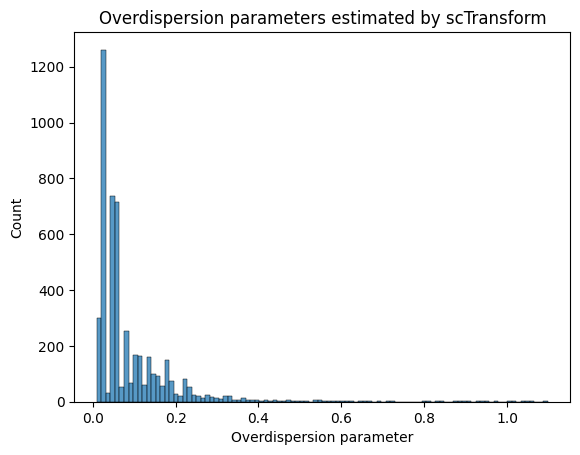

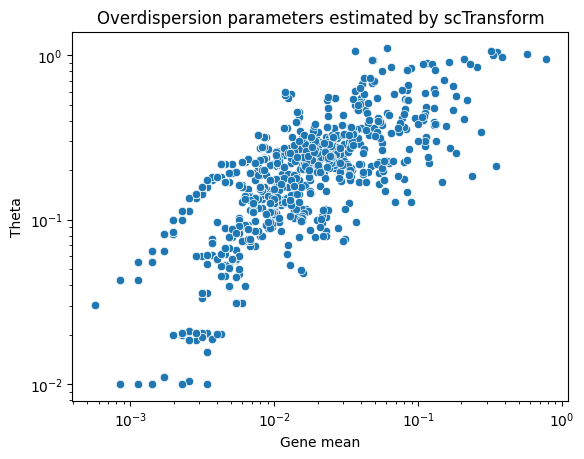

In [248]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [249]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [250]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# sc.pp.highly_variable_genes(data_gene, n_top_genes=5000, flavor="seurat_v3", layer="counts", span=1)
data_gene = data_gene[:, data_gene.var.highly_variable]
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

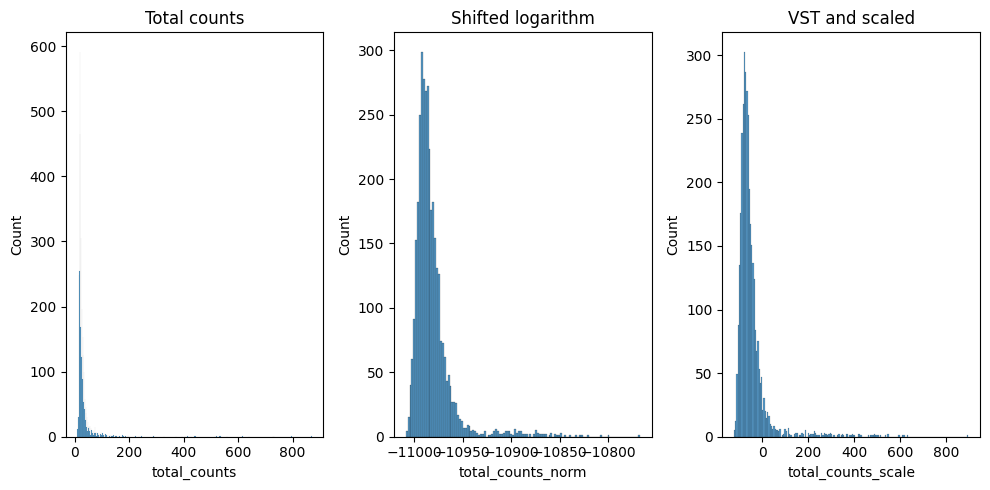

In [251]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

In [252]:
print(data_gene.var["species"].value_counts())
print(data_gene)

K.pneumoniae    1098
E.coli           554
P.Aeruginosa     520
E.faecium        446
Name: species, dtype: int64
AnnData object with n_obs × n_vars = 3525 × 2618
    obs: 'species', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'species', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'species_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'


## Count-splitting into train and test data

In [253]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 3502 × 1238
    obs: 'species', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'species', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'


In [254]:
print(data_train.var["species"].value_counts())

K.pneumoniae    704
P.Aeruginosa    231
E.coli          181
E.faecium       122
Name: species, dtype: int64


In [255]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
data_train.X[np.isnan(data_train.X)] = 0
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
data_test.X[np.isnan(data_test.X)] = 0
sc.tl.pca(data_test, svd_solver='arpack')

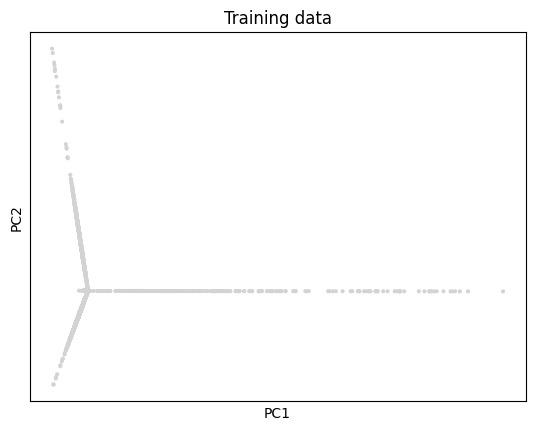

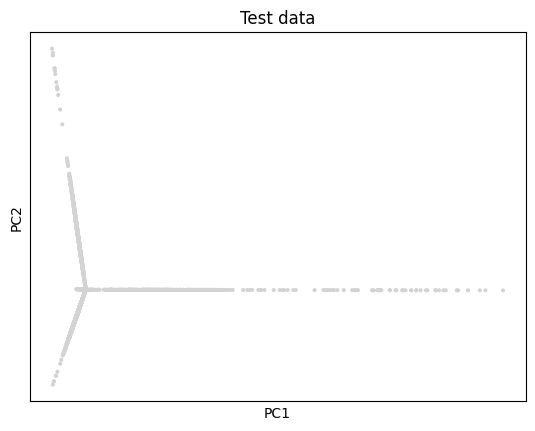

In [256]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [257]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:6


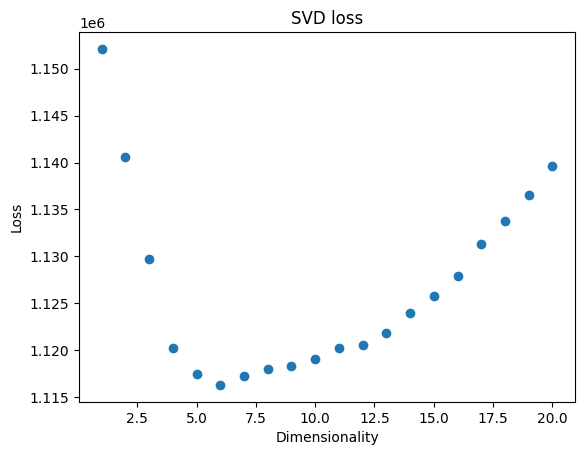

In [258]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

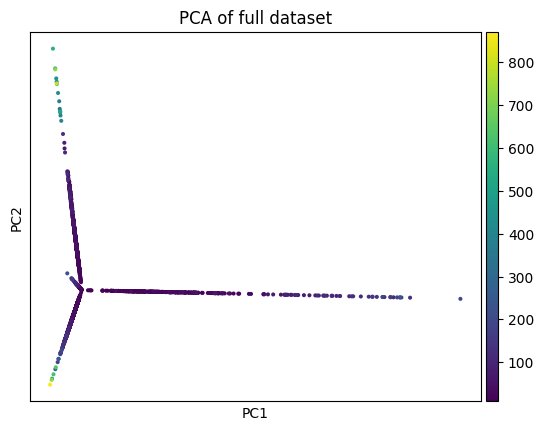

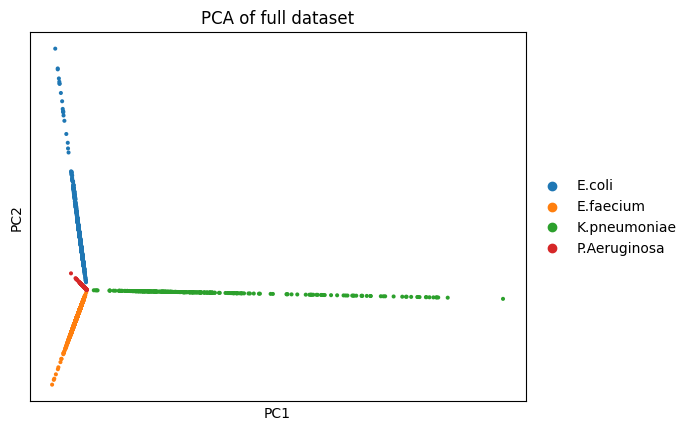

In [259]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

sc.pl.pca(data_gene, color="species", cmap="viridis", title="PCA of full dataset")
plt.show()

In [260]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [261]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

677


In [262]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="S3_filtered_scdeed_temp")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 40
Optimal min_dist: 0.05


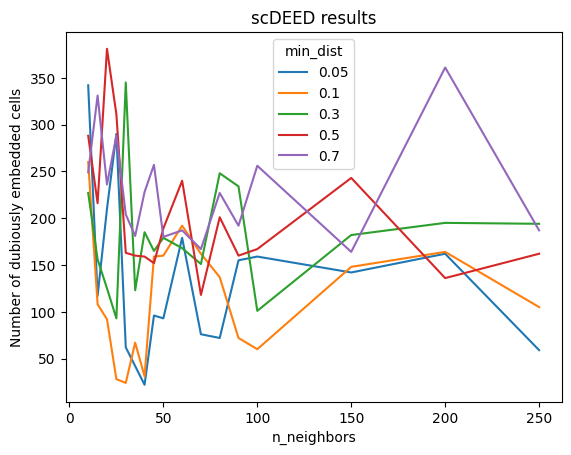

In [263]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [264]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


# k_opt = 4
n_neighbors_opt = 30
min_dist_opt = 0.3
print(k_opt)

6


In [265]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [266]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=2345)


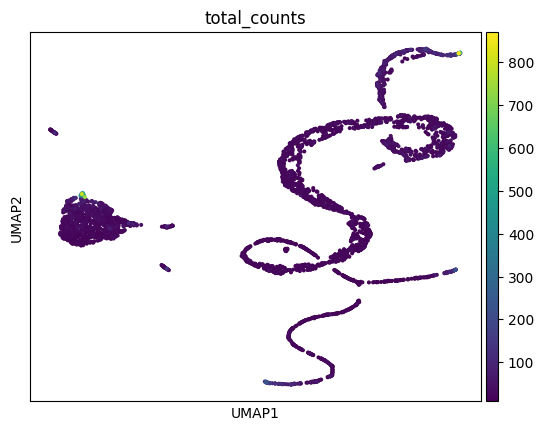

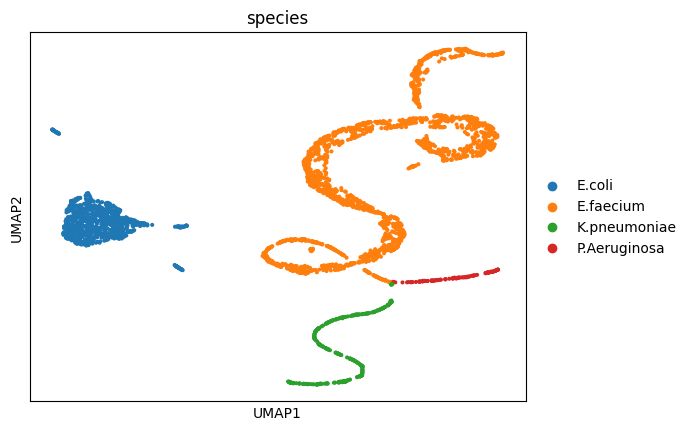

In [267]:
# sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
# plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

sc.pl.umap(data_gene, color="species", alpha=1, cmap="viridis")
plt.show()

In [268]:
data_path = "../../data/BacDrop"

data_gene.write(data_path + "/4species_data_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [269]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

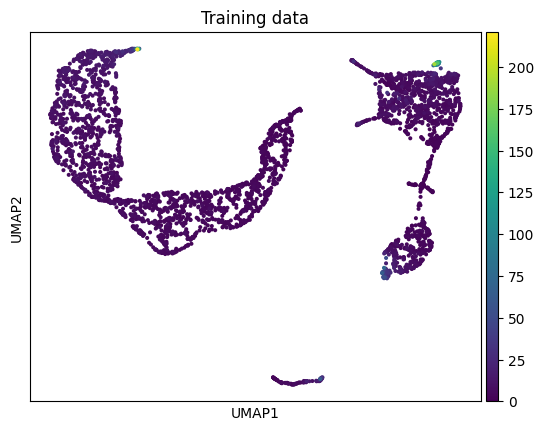

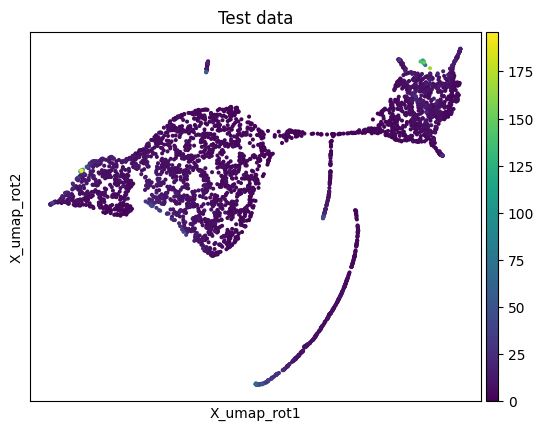

In [270]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [271]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

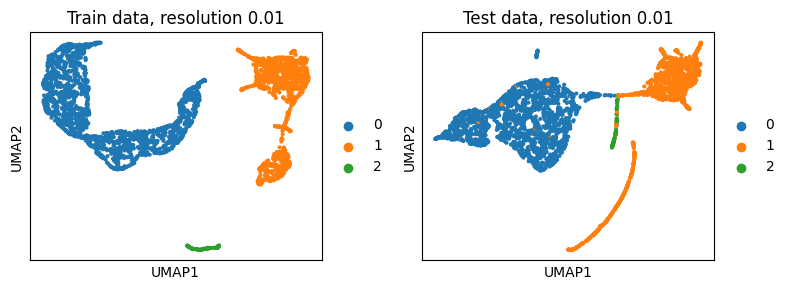

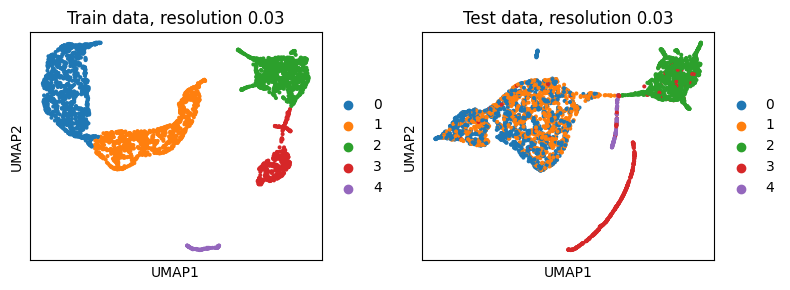

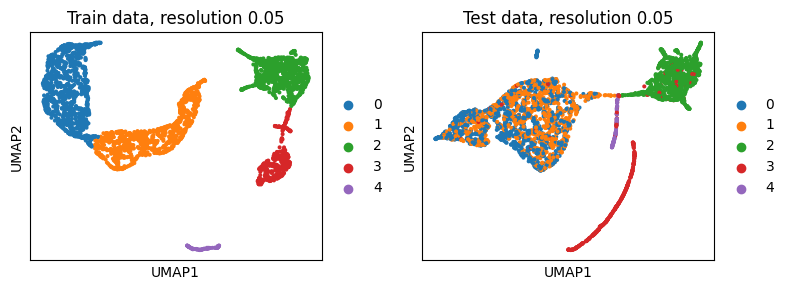

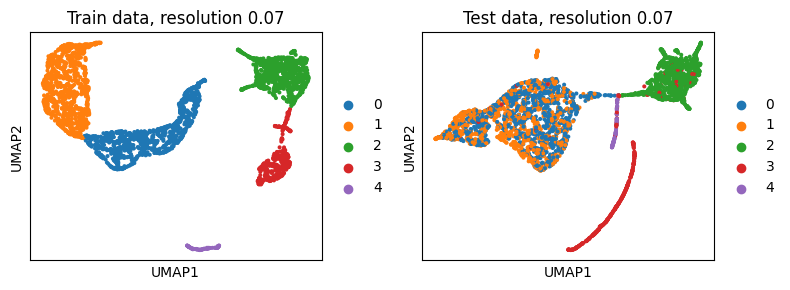

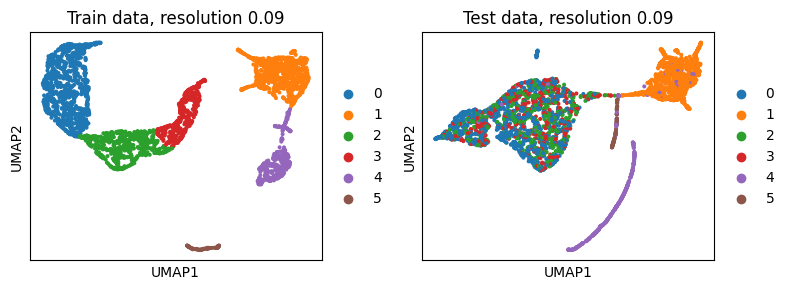

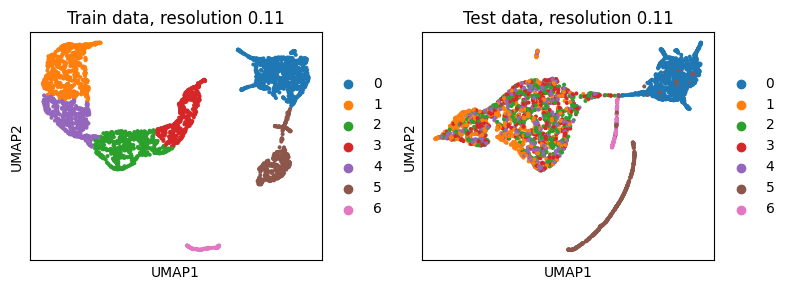

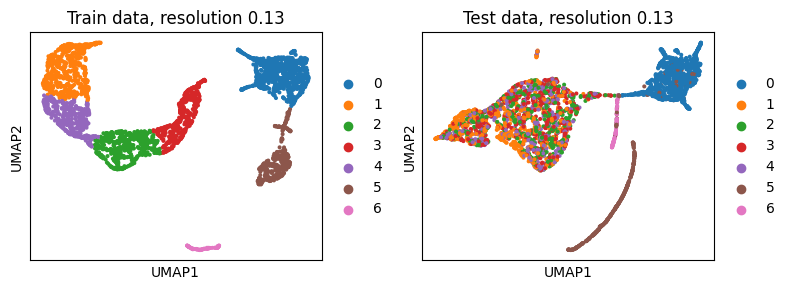

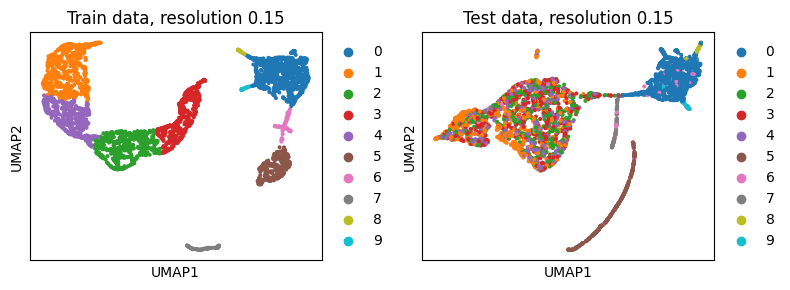

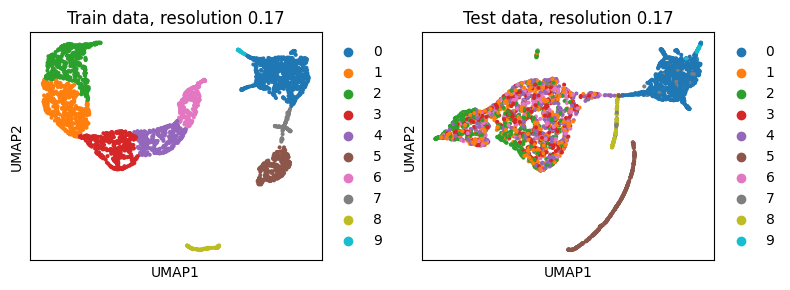

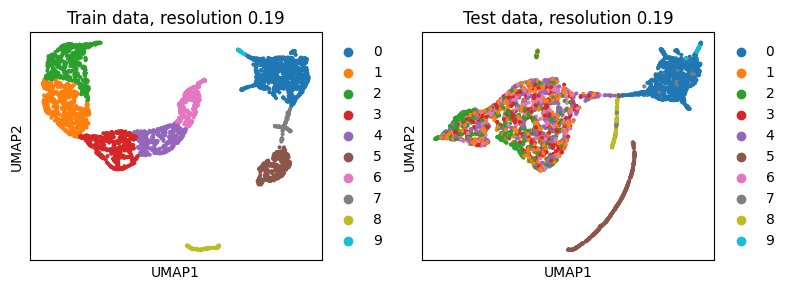

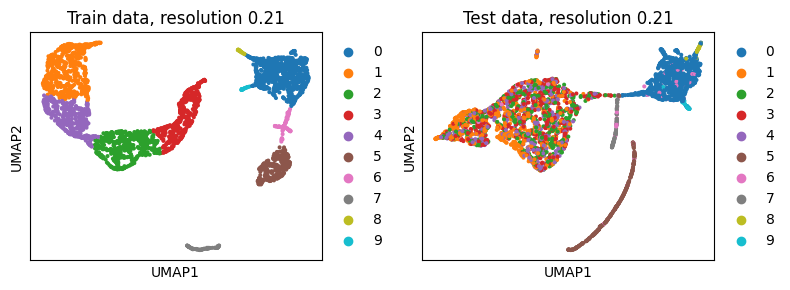

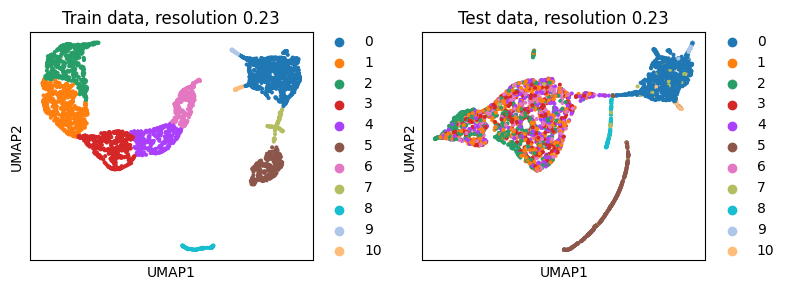

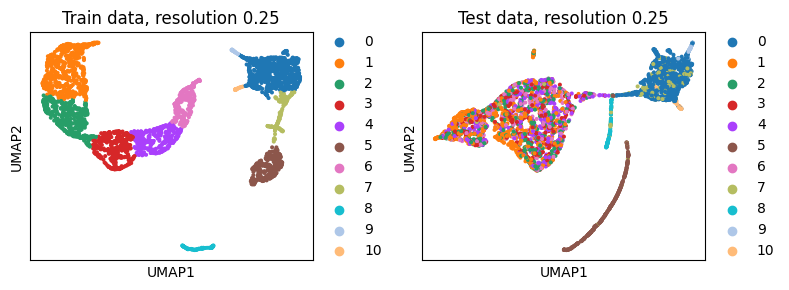

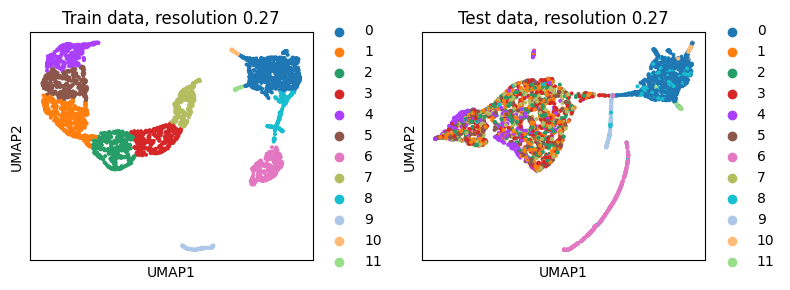

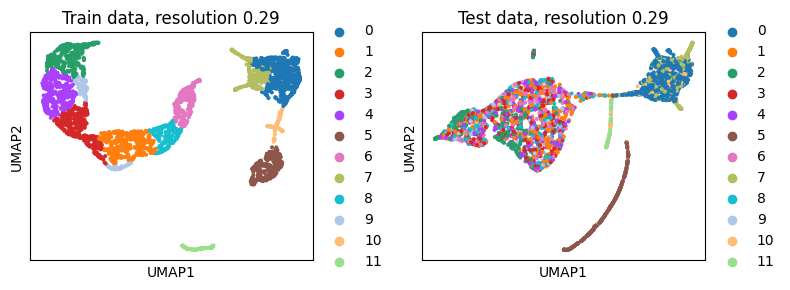

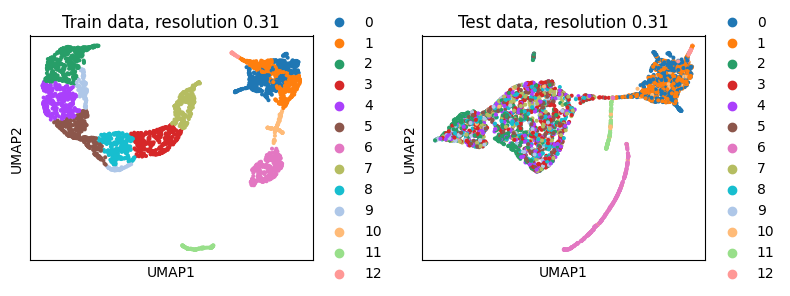

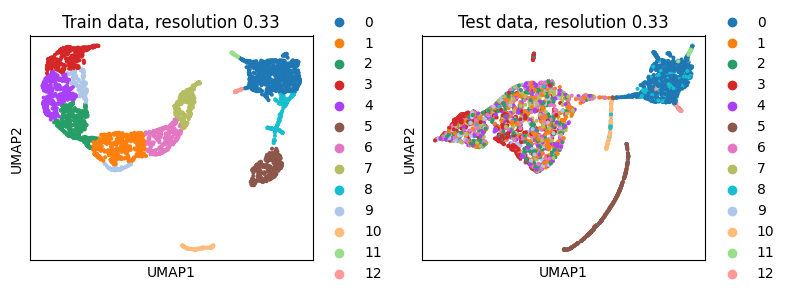

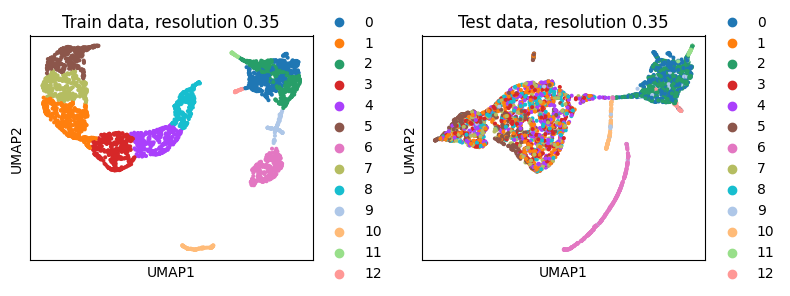

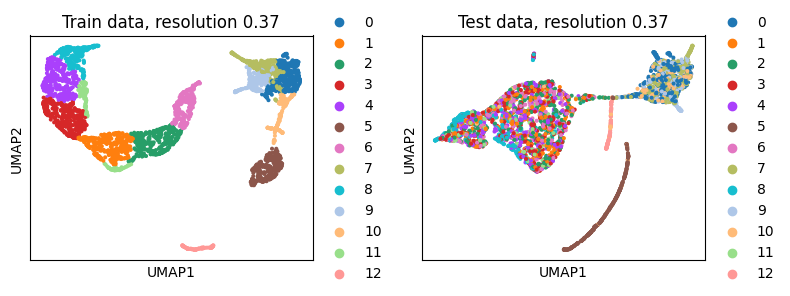

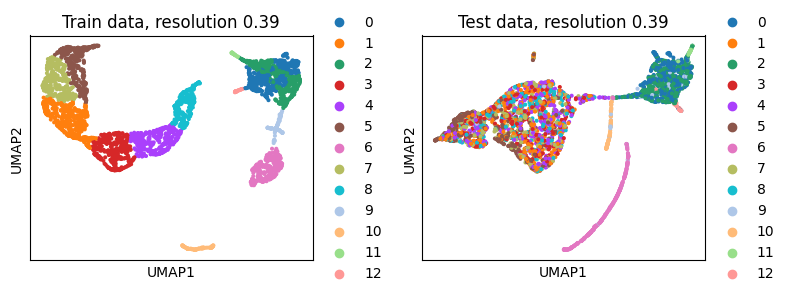

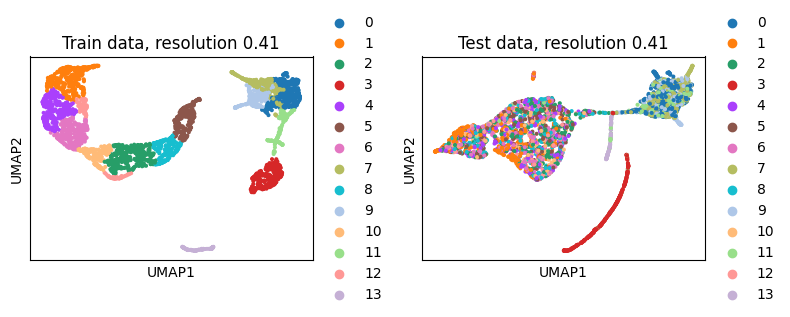

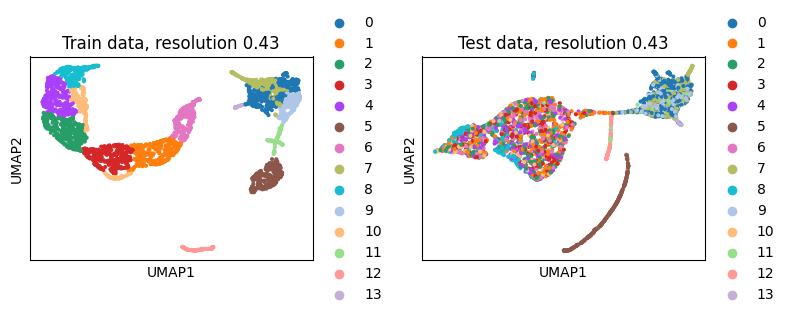

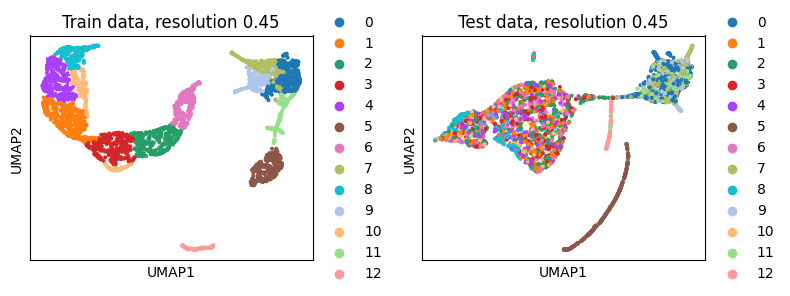

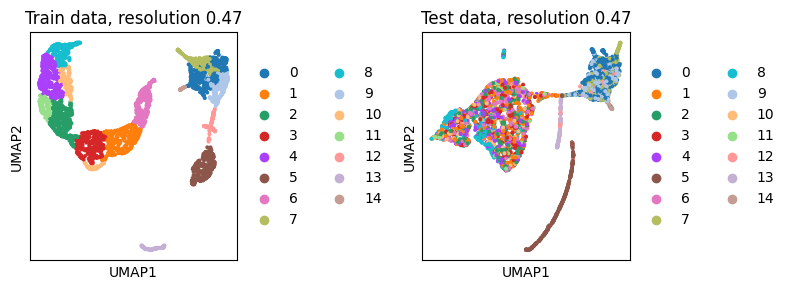

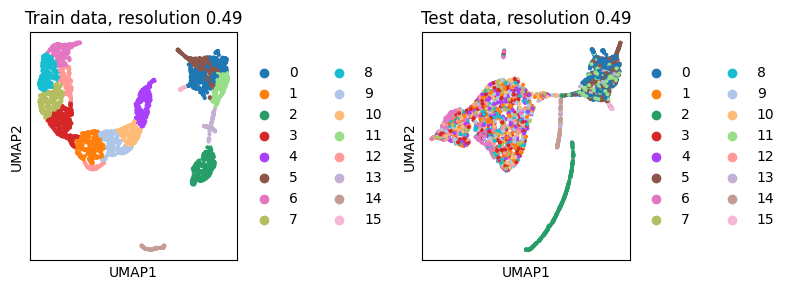

In [272]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [273]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 3 - Train: 0.494 - Test: 0.483 - Random: 0.247
resolution: 0.03 - clusters: 5 - Train: 0.486 - Test: 0.337 - Random: 0.125
resolution: 0.05 - clusters: 5 - Train: 0.481 - Test: 0.332 - Random: 0.118
resolution: 0.07 - clusters: 5 - Train: 0.475 - Test: 0.328 - Random: 0.112
resolution: 0.09 - clusters: 6 - Train: 0.471 - Test: 0.286 - Random: 0.087
resolution: 0.11 - clusters: 7 - Train: 0.467 - Test: 0.254 - Random: 0.069
resolution: 0.13 - clusters: 7 - Train: 0.464 - Test: 0.25 - Random: 0.064
resolution: 0.15 - clusters: 10 - Train: 0.459 - Test: 0.239 - Random: 0.057
resolution: 0.17 - clusters: 10 - Train: 0.455 - Test: 0.227 - Random: 0.05
resolution: 0.19 - clusters: 10 - Train: 0.452 - Test: 0.224 - Random: 0.046
resolution: 0.21 - clusters: 10 - Train: 0.449 - Test: 0.229 - Random: 0.048
resolution: 0.23 - clusters: 11 - Train: 0.446 - Test: 0.216 - Random: 0.039
resolution: 0.25 - clusters: 11 - Train: 0.444 - Test: 0.197 - Random: 0.034
resoluti

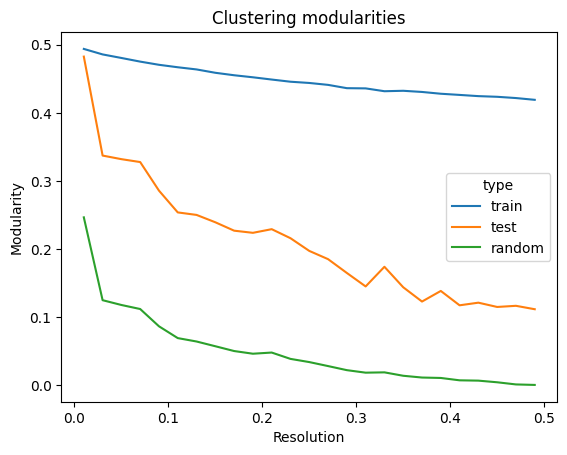

In [274]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

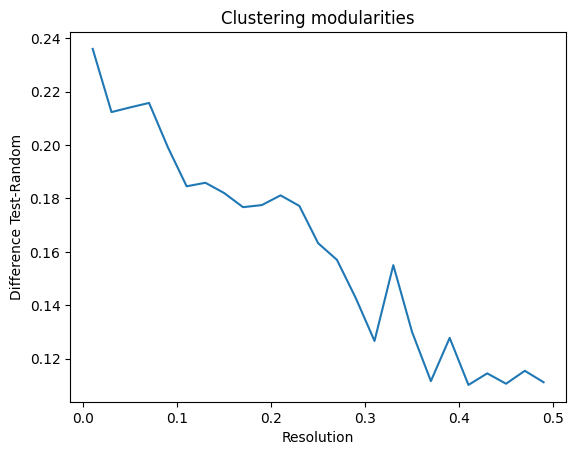

In [275]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [276]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

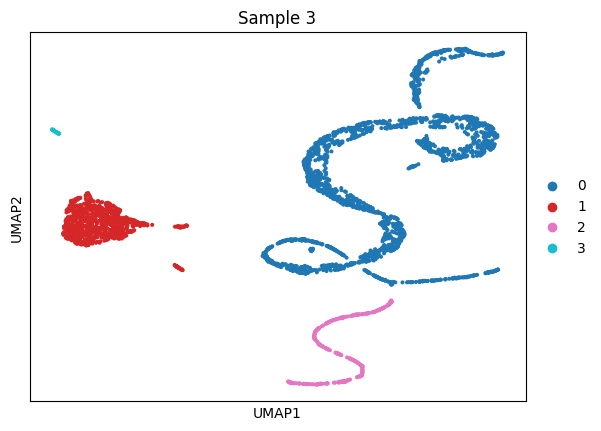

In [277]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [278]:
data_gene.write(data_path + "/4species_data_processed.h5ad")

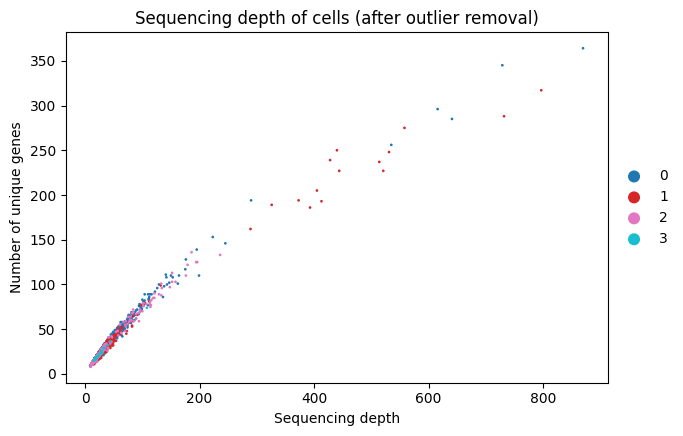

In [279]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

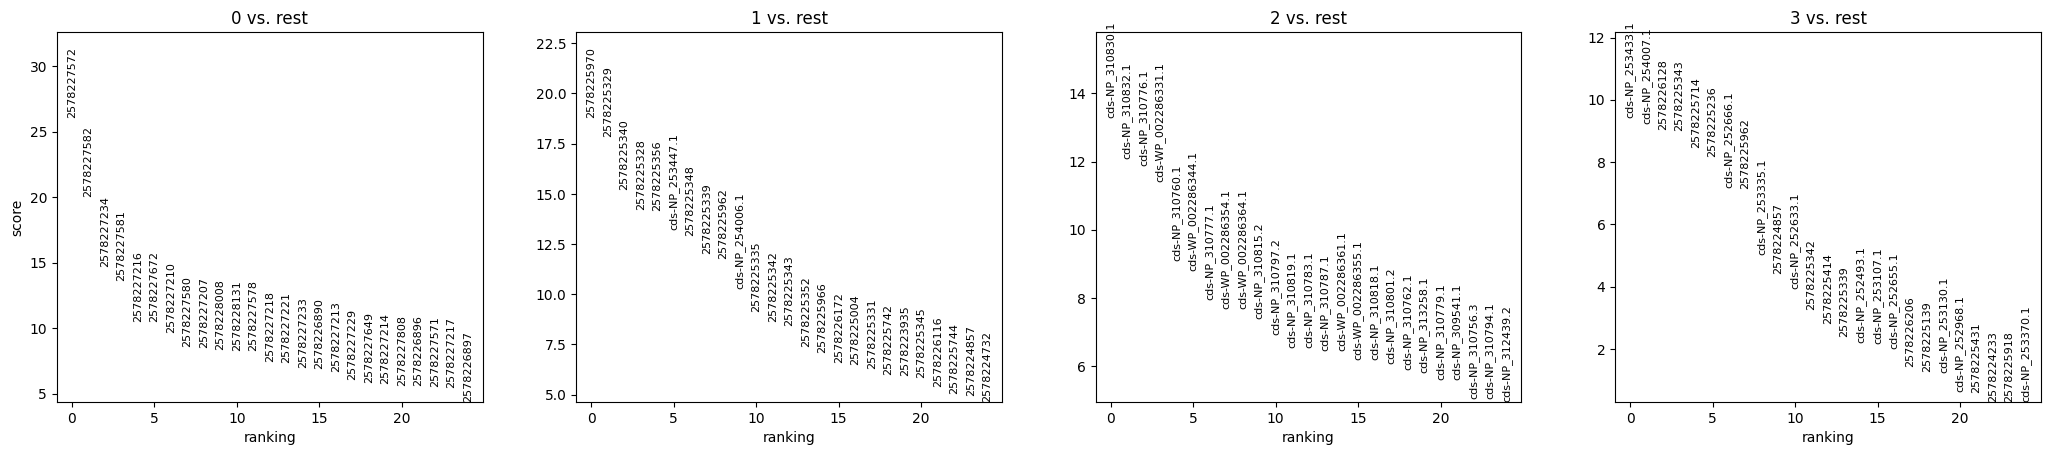

In [280]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

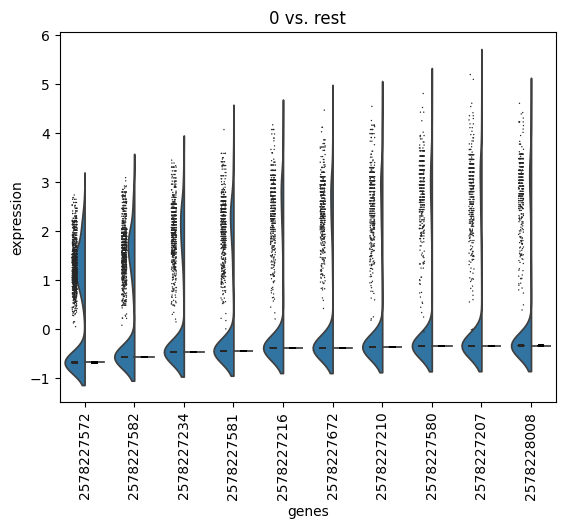

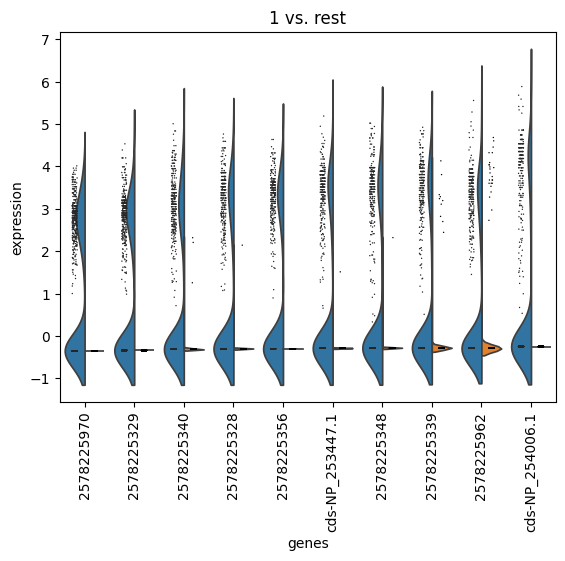

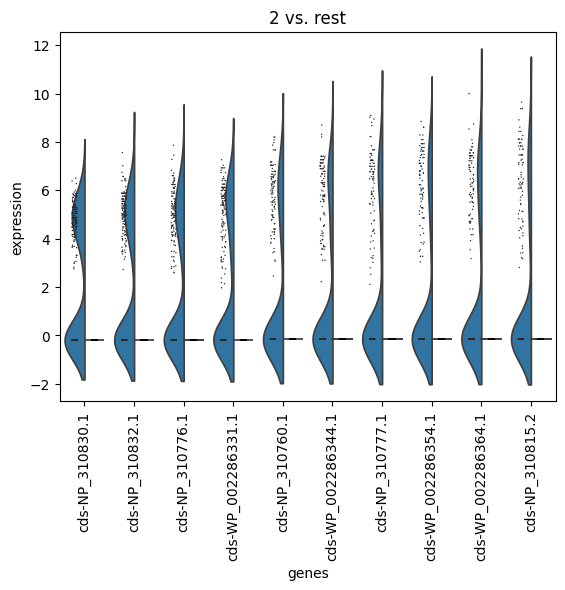

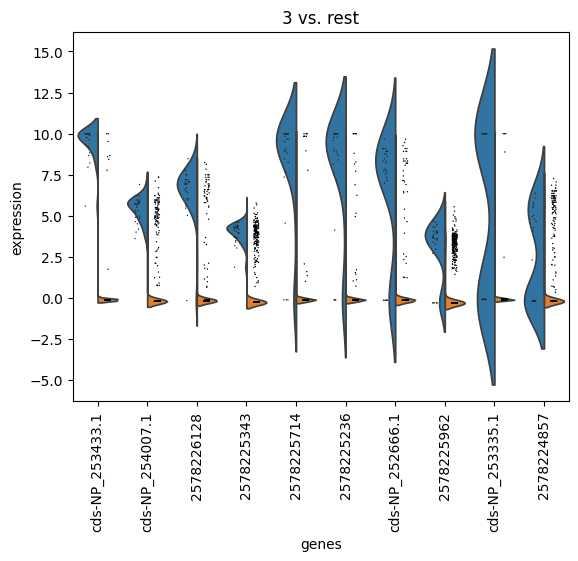

In [281]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)